# Importation de la base de données 

- sert a lire un fichier CSV  
- Afficher les premières lignes sous forme de DataFrame pandas

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

ROOT = Path("..")/ ".."            
DATA_DIR = ROOT / "Data"
CSV_PATH = DATA_DIR / "parfums_data_base_machineLearning.csv"

df = pd.read_csv(CSV_PATH, encoding="utf-8")
df.head()

,Marque,Famille,Sous_famille,Parfumeur,Prix_Categorie,Fragrance,Origine,Genre,Année,Ingredients_txt,Concepts_txt
0,Commodity,CITRUS,FRUITÉ,Caroline Sabas,Niche,ICE(d) EXPRESSIVE,États-Unis d'Amérique,Unisexe,2025,gingembre eucalyptus menthe crépue fève tonka ...,quotidien eté optimiste liberté jour printemps...
1,Commodity,CITRUS,FRUITÉ,Caroline Sabas,Niche,ICE(d) + BOLD,États-Unis d'Amérique,Unisexe,2025,menthe crépue cardamome ambre eucalyptus fève ...,quotidien eté optimiste liberté jour printemps...
2,Commodity,CITRUS,FRUITÉ,Caroline Sabas,Niche,ICE(d) – PERSONAL,États-Unis d'Amérique,Unisexe,2025,algues accord peau eucalyptus mangue bois de s...,quotidien eté optimiste liberté jour printemps...
3,4711,BOISÉ,BOISÉ,Anton (Jimmy) Studer,Niche,WHITE CEDAR,Allemagne,Unisexe,2025,bois de santal iris violette cèdre ambre gris ...,intense riche robuste puissant boisé quotidien...
4,Dior,BOISÉ,AMBRÉ (ORIENTAL),Francis Kurkdjian,Prestige,SAUVAGE RARE BLEND 2025,France,Homme,2025,ciste labdanum oud bois dagar vanille madagascar,intense riche robuste puissant boisé hiver mar...


# Séparer les caractéristiques (X) et la cible (y)

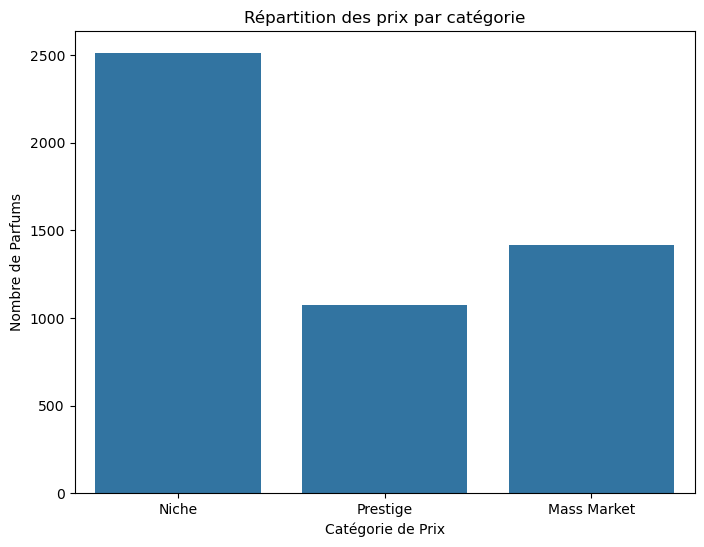

In [4]:
y = df["Prix_Categorie"]
X = df.drop(columns=["Prix_Categorie","Fragrance", "Marque"])

# visualiser la répartition des prix par catégorie
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title("Répartition des prix par catégorie")
plt.xlabel("Catégorie de Prix")
plt.ylabel("Nombre de Parfums")
plt.show()

- On remarque que la catégorie "Niche" est la plus représentée, suivie de "Mass Market" et "prestige".
- On a donc un dataset déséquilibré, donc pour le choix du modèle on va utiliser des métriques adaptées qui est "le f1-score"

# Gérer les valeurs manquantes

In [5]:
text_cols = ["Ingredients_txt", "Concepts_txt"]
cat_cols = [ "Famille", "Sous_famille", "Parfumeur", "Origine", "Genre"]
num_cols = ["Année"]

X["Ingredients_txt"] = X["Ingredients_txt"].fillna("")
X["Concepts_txt"] = X["Concepts_txt"].fillna("")

for c in cat_cols:
    X[c] = X[c].fillna("Inconnu")

X["Année"] = X["Année"].fillna(X["Année"].median())


# Decoupage des données en ensembles d'entraînement et de test

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=1)

# PREPROCESSING PIPELINE

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

preprocess = ColumnTransformer(
    transformers=[
        ("ing", TfidfVectorizer(min_df=5, ngram_range=(1, 2)), "Ingredients_txt"),
        ("con", TfidfVectorizer(min_df=5, ngram_range=(1, 2)), "Concepts_txt"),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

### DUMMY CLASSIFIER

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report

dummy_clf = Pipeline([
    ("prep", preprocess),
    ("clf", DummyClassifier(strategy="most_frequent"))
])

dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)

print("F1 macro (Dummy):", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

F1 macro (Dummy): 0.22281355330849742
              precision    recall  f1-score   support

 Mass Market       0.00      0.00      0.00       354
       Niche       0.50      1.00      0.67       628
    Prestige       0.00      0.00      0.00       269

    accuracy                           0.50      1251
   macro avg       0.17      0.33      0.22      1251
weighted avg       0.25      0.50      0.34      1251



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### LOGISTIC REGRESSION

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, roc_curve

logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=5000))
])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("F1 macro regression :", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

F1 macro regression : 0.7075010795480946
              precision    recall  f1-score   support

 Mass Market       0.75      0.68      0.72       354
       Niche       0.80      0.88      0.84       628
    Prestige       0.61      0.54      0.57       269

    accuracy                           0.75      1251
   macro avg       0.72      0.70      0.71      1251
weighted avg       0.74      0.75      0.74      1251



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### K-NEAREST NEIGHBORS 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder


# Encode y correctement (train + test)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

knn = Pipeline([
    ("prep", preprocess),
    ("clf", KNeighborsClassifier())
])

param_grid = {
    "clf__n_neighbors": np.arange(3, 25, 1),
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],
}

grid_knn = GridSearchCV(
    knn,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    error_score="raise"  
)

grid_knn.fit(X_train, y_train_enc)

print("Meilleurs paramètres :", grid_knn.best_params_)
print("Meilleur F1 macro CV :", grid_knn.best_score_)

best_knn = grid_knn.best_estimator_
y_pred_enc = best_knn.predict(X_test)

print("F1 macro test :", f1_score(y_test_enc, y_pred_enc, average="macro"))
print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_))


Meilleurs paramètres : {'clf__n_neighbors': 16, 'clf__p': 2, 'clf__weights': 'distance'}
Meilleur F1 macro CV : 0.6560195172552687
F1 macro test : 0.663155981255409
              precision    recall  f1-score   support

 Mass Market       0.69      0.70      0.69       354
       Niche       0.76      0.89      0.82       628
    Prestige       0.64      0.38      0.48       269

    accuracy                           0.73      1251
   macro avg       0.70      0.66      0.66      1251
weighted avg       0.71      0.73      0.71      1251



### ARBRE DE DÉCISION

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

dt = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier())
])

param_grid_dt = {
    "clf__max_depth": np.arange(5, 50, 5),
    "clf__min_samples_split": np.arange(2, 20, 1),
    "clf__min_samples_leaf": np.arange(1, 10, 1),
    "clf__criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    dt,
    param_grid=param_grid_dt,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    error_score=0.0
)

grid_dt.fit(X_train, y_train)

print("Meilleurs paramètres DecisionTree :", grid_dt.best_params_)
print("Meilleur score CV (F1 macro) :", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("F1 macro test (DecisionTree) :", f1_score(y_test, y_pred_dt, average="macro"))



Meilleurs paramètres DecisionTree : {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 19}
Meilleur score CV (F1 macro) : 0.7144843019687706
F1 macro test (DecisionTree) : 0.7036805155668205


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier())
    ])

param_grid_rf = {
    "clf__n_estimators": np.arange(50, 250, 50),
    "clf__max_depth": np.arange(5, 20, 1),
    "clf__min_samples_split": np.arange(2, 10, 1),
    "clf__min_samples_leaf": np.arange(1, 10, 1),
    "clf__criterion": ["gini", "entropy"]}

grid_rf = GridSearchCV(
    rf,
    param_grid=param_grid_rf,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    error_score=0.0)

grid_rf.fit(X_train, y_train)
print("Meilleurs paramètres RandomForest :", grid_rf.best_params_)
print("Meilleur score CV (F1 macro) RandomForest :", grid_rf.best_score_)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("F1 macro test (RandomForest) :", f1_score(y_test, y_pred_rf, average="macro"))
print(classification_report(y_test, y_pred_rf))


Meilleurs paramètres RandomForest : {'clf__criterion': 'entropy', 'clf__max_depth': 19, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Meilleur score CV (F1 macro) RandomForest : 0.6182325038852184
F1 macro test (RandomForest) : 0.5746433032198747
              precision    recall  f1-score   support

 Mass Market       0.71      0.59      0.64       354
       Niche       0.68      0.95      0.79       628
    Prestige       0.62      0.19      0.29       269

    accuracy                           0.68      1251
   macro avg       0.67      0.57      0.57      1251
weighted avg       0.68      0.68      0.64      1251



### SUPPORT VECTOR MACHINE

In [ ]:
from sklearn.svm import SVC

svm_clf = Pipeline([
    ("prep", preprocess),
    ("clf", SVC())])

svm_grid = {
    "clf__C": np.arange(0.1,2,0.1),
    "clf__kernel": ["linear", "rbf"],
    "clf__gamma": ["scale", "auto"]}

grid_svm = GridSearchCV(
    svm_clf,
    param_grid=svm_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    error_score=0.0)

grid_svm.fit(X_train, y_train)
y_pred = grid_svm.predict(X_test)

print("Meilleurs paramètres DecisionTree :", grid_svm.best_params_)
print("Meilleur score CV (F1 macro) :", grid_svm.best_score_)
print("F1 macro SVM :", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))  



Meilleurs paramètres DecisionTree : {'clf__C': 0.4, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Meilleur score CV (F1 macro) : 0.7229988605345568
F1 macro SVM : 0.7136316700812193
              precision    recall  f1-score   support

 Mass Market       0.75      0.68      0.71       354
       Niche       0.80      0.89      0.85       628
    Prestige       0.63      0.54      0.58       269

    accuracy                           0.76      1251
   macro avg       0.73      0.70      0.71      1251
weighted avg       0.75      0.76      0.75      1251



### GAUSSIAN NAIVE BAYES

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB

dense = FunctionTransformer(lambda X: X.toarray(), accept_sparse=True)

pipe = Pipeline([
    ("prep", preprocess),
    ("to_dense", dense),
    ("clf", GaussianNB()),
])

pipe.fit(X_train, y_train)

print("F1 macro GaussianNB :", f1_score(y_test, pipe.predict(X_test), average="macro"))
# Évaluation test


F1 macro GaussianNB : 0.5239731392297603


### GAUSSIAN PROCESS CLASSIFIER

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier

gpc = Pipeline([
    ("prep", preprocess),
    ("to_dense", dense),
    ("clf", GaussianProcessClassifier())
])

gpc.fit(X_train, y_train)
y_pred = gpc.predict(X_test)
print("F1 macro GPC :", f1_score(y_test, y_pred, average="macro"))

F1 macro GPC : 0.6649132525473864


### NEURAL NETWORK MLP CLASSIFIER

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline([
    ("prep", preprocess),
    ("clf", MLPClassifier(max_iter=5000))])

nnm_grid = {
    "clf__hidden_layer_sizes": [(50,), (100,), (50,50), (100,50)],
    "clf__activation": ["relu", "tanh"],
    "clf__solver": ["adam", "sgd"],
    "clf__alpha": [0.0001, 0.001, 0.01],}

grid_mlp = GridSearchCV(
    mlp,
    param_grid=nnm_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    error_score=0.0
)
grid_mlp.fit(X_train, y_train)
y_pred = grid_mlp.predict(X_test)
print("F1 macro MLPClassifier :", f1_score(y_test, y_pred, average="macro"))
print("Meilleurs paramètres MLPClassifier :", grid_mlp.best_params_)
print("Meilleur score CV (F1 macro) MLPClassifier :", grid_mlp.best_score_)
best_mlp = grid_mlp.best_estimator_


F1 macro MLPClassifier : 0.6607982652840954
Meilleurs paramètres MLPClassifier : {'clf__activation': 'relu', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (50,), 'clf__solver': 'adam'}
Meilleur score CV (F1 macro) MLPClassifier : 0.6976341931318799


### BOOSTING CLASSIFIERS

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import  GridSearchCV
from sklearn.pipeline import Pipeline

gbc = Pipeline([
    ("prep", preprocess),
    ("clf", GradientBoostingClassifier()),])

bost_grid = {
    "clf__n_estimators": np.arange(50, 250, 50),
    "clf__learning_rate": [0.1, 1, 0.1],
    "clf__max_depth": np.arange(2, 10, 1),
    "clf__subsample": np.arange(0.5, 1.0, 0.1),}

grid_gbc = GridSearchCV(
    gbc,
    param_grid=bost_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    error_score=0.0)

grid_gbc.fit(X_train, y_train)
y_pred = grid_gbc.predict(X_test)
print("F1 macro GradientBoostingClassifier :", f1_score(y_test, y_pred, average="macro"))
print("Meilleurs paramètres GradientBoostingClassifier :", grid_gbc.best_params_)


F1 macro GradientBoostingClassifier : 0.7403340466747329
Meilleurs paramètres GradientBoostingClassifier : {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 150, 'clf__subsample': 0.7999999999999999}


#### Importance des variables pour le modeles boosting 

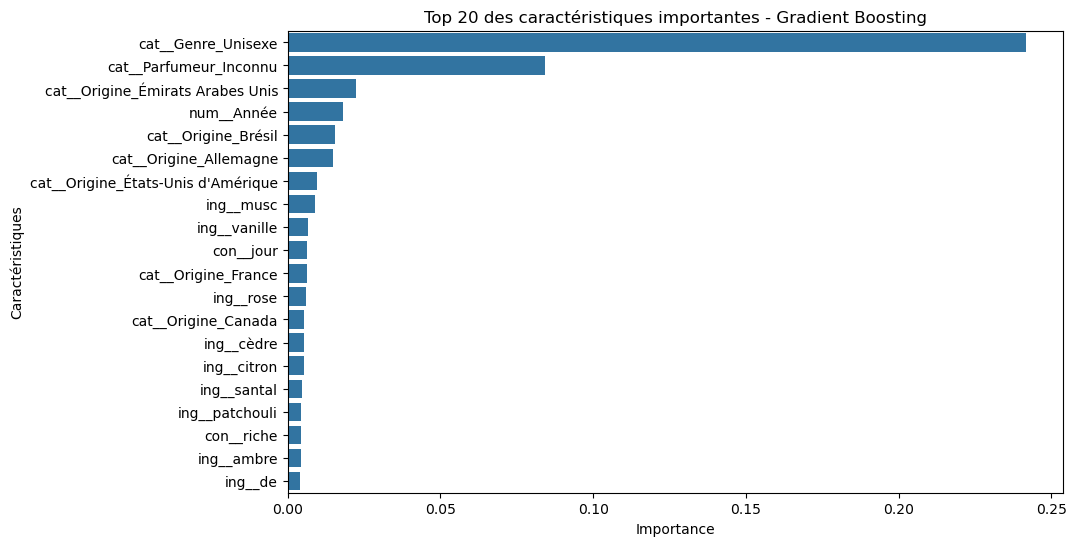

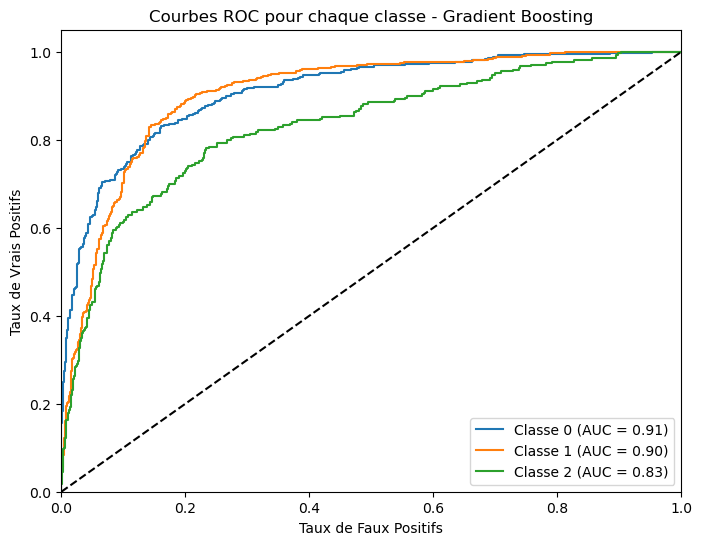

In [ ]:
best_gbc = grid_gbc.best_estimator_
feature_names = best_gbc.named_steps['prep'].get_feature_names_out()
importances = best_gbc.named_steps['clf'].feature_importances_
feature_importances = pd.Series(importances, index=feature_names)
top_features = feature_importances.nlargest(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 20 des caractéristiques importantes - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Caractéristiques")
plt.show()


# courbe ROC boosting
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = best_gbc.predict_proba(X_test)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC pour chaque classe - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()


# Comparaison des modèles

In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

resultats = []

# Dummy
y_pred = dummy_clf.predict(X_test)
resultats.append({
    "Modèle": "Dummy",
    "F1_macro_test": f1_score(y_test, y_pred, average="macro")})

# Logistic Regression
y_pred = logreg.predict(X_test)
resultats.append({
    "Modèle": "Logistic Regression",
    "F1_macro_test": f1_score(y_test, y_pred, average="macro")})

# KNN 
y_pred = best_knn.predict(X_test)
resultats.append({
    "Modèle": "KNN ",
    "F1_macro_test": f1_score(y_test, y_pred, average="macro")})

# Decision Tree 
y_pred = best_dt.predict(X_test)
resultats.append({
    "Modèle": "Decision Tree",
    "F1_macro_test": f1_score(y_test, y_pred, average="macro")})

# SVM 
y_pred = grid_svm.best_estimator_.predict(X_test)
resultats.append({
    "Modèle": "SVM",
    "F1_macro_test": f1_score(y_test, y_pred, average="macro")})

# Gaussian Naive Bayes
y_pred = pipe.predict(X_test)
resultats.append({
    "Modèle": "Gaussian Naive Bayes",
    "F1_macro_test": f1_score(y_test, y_pred, average="macro")})

# MLP
y_pred = best_mlp.predict(X_test)
resultats.append({
    "Modèle": "Neural Network ",
    "F1_macro_test": f1_score(y_test, y_pred, average="macro")})

# Gaussian Process Regressor
y_pred = gpc.predict(X_test)
resultats.append({
    "Modèle": "Gaussian Process Classifier",
    "F1_macro_test": f1_score(y_test, y_pred, average="macro")})

# Random Forest
y_pred = best_rf.predict(X_test)
resultats.append({
    "Modèle": "Random Forest",
    "F1_macro_test": f1_score(y_test, y_pred, average="macro")})

# Boosting
y_pred = grid_gbc.predict(X_test)
resultats.append({
    "Modèle": "Gradient Boosting Classifier",
    "F1_macro_test": f1_score(y_test, y_pred, average="macro")})

# DataFrame final
df_resultats = pd.DataFrame(resultats, 
                            columns=["Modèle", "F1_macro_test"],).sort_values(by="F1_macro_test",
                                        ascending=False)

df_resultats
# ici on a choisi le Gradient Boosting Classifier comme meilleur modèle 

,Modèle,F1_macro_test
9,Gradient Boosting Classifier,0.740334
4,SVM,0.713632
1,Logistic Regression,0.706301
3,Decision Tree,0.703681
7,Gaussian Process Classifier,0.664913
2,KNN,0.662308
6,Neural Network,0.660798
8,Random Forest,0.574643
5,Gaussian Naive Bayes,0.523973
0,Dummy,0.222814


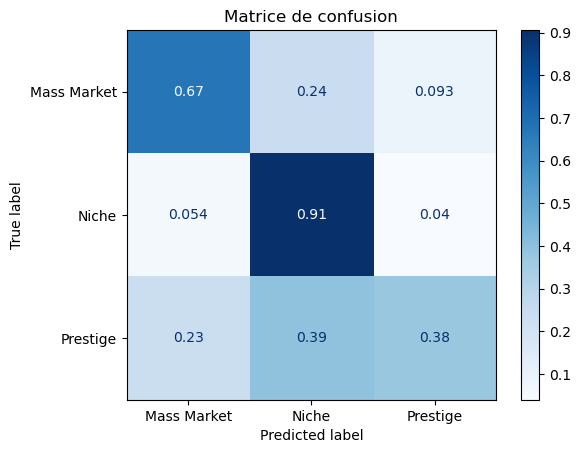

In [19]:
# Matrice de confusion pour le meilleur modèle
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
best_model = best_mlp
y_pred = best_model.predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap=plt.cm.Blues,
    normalize="true"
)
disp.ax_.set_title("Matrice de confusion")
plt.show()

In [21]:
# Sauvegarde du meilleur modèle
import joblib
best_model = best_mlp
joblib.dump(best_model, "best_model.pkl")


['best_model.pkl']